# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

Set up environment and read in data. 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats.weightstats
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
#load dataframe info variable data
data = pd.io.stata.read_stata('us_job_market_discrimination.dta')

In [22]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [3]:
# number of callbacks for black-sounding names
print(sum(data[data.race=='b'].call), sum(data[data.race=='w'].call))

(157.0, 235.0)


For easier analysis, seperate the dataframe into two separate dataframes where race is either 'b' or 'w'.

In [4]:
df_w = data[data.race=='w']
df_b = data[data.race=='b']

### 1. What test is appropriate for this problem? Does CLT apply?
Since we will be comparing the categorical differences between two variables in which the item being measured is 'true' or 'false, (1 and 0 respectively), it seems appropriate to do a two sample A/B test in which the test statistic is the difference in the fraction of 'true' responses of total entries. CLT does not apply here do to the categorical nature of the data being tested (since there only 2 possible entries for distributing). 

### 2. What are the null and alternate hypotheses?
The null hypothesis for this test would be that there is no difference in the fraction of call-backs between black-appearing and white-appearing applicatants; in essence that race has no affect on rate of call-backs. Conversly, the alternate hypothesis would be that apparent race of an applicant has an effect on whether or not that applicant recieves a call-back. 

First, define all the functions needed to compute a sample of difference in 'true' (represented by a 1) responses. This will be done by permutating the data, resampling the data by computing the difference in permutations, and creating an array from these resamples. 

Mathematically, the mean is the sum of all true responses (represented by 1s) and all false responses (represented by zeros) divided by the total number of entries, and is equivilent to the faction of yes responses out of total responses, all of these functions are not necessary but are useful to see what is going on under the hood of these calculations.

In [5]:
#calculates the difference in fraction of 1s and 0s
def diff_frac(data1, data2):
    frac_a = np.sum(data1) / len(data1)
    frac_b = np.sum(data2) / len(data2)
    return frac_b - frac_a

#creates a permutation sample from two 1-dimensional data sets
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

#draws 'size' number of permutation samples and returns an array of the data after apply 'func' to it
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

#define a function to draw bootstrapped samples of the data
def draw_bs_samples(data, func, size=1):
    """define a function to draw bootstrapped samples of a 1-dimensional set of data, apply a function, 
        and return an array of a predetermined size"""
    bs_sample = np.empty(size)
    for i in range(size):
        bs_sample[i] = func(np.random.choice(data, size=len(data)))
    return bs_sample

#compute the test statistic, difference in fraction of true responses.
obs_diff_fracs = diff_frac(df_w.call, df_b.call)

### 3. Compute margin of error, confidence interval, and p-value.

First compute the mean call-back rate for both black and white applicants. Remeber, mathematically, the mean is the sum of all true responses (represented by 1s) and all false responses (represented by zeros) divided by the total number of entries, and is equivilent to the faction of yes responses out of total responses.

In [6]:
print(np.mean(df_b.call), np.mean(df_w.call))

(0.0644763857126236, 0.09650924056768417)


#### Confidence Interval and Error
Compute the confidence 95th percentile confidence interval.

In [8]:
#bootstrap samples of the 'yes' responses
samples_b = draw_bs_samples(df_b.call, np.mean, 10000)
samples_w = draw_bs_samples(df_w.call, np.mean, 10000)

#compute 95th percentile
con_int_b = np.percentile(samples_b, [2.5, 97.5])
con_int_w = np.percentile(samples_w, [2.5, 97.5])

print("95th percentile black: ", con_int_b)
print("95th percentile white: ", con_int_w)

('95th percentile black: ', array([ 0.05462012,  0.07433265]))
('95th percentile white: ', array([ 0.08501027,  0.10841889]))


As we can see, applications marked 'b' are likly to recieve a callback from 5.5% to 7.4% of the time, vs applications marked 'w' are likely to recieve a callback from 8.5% to 10.8% of the time (with a 5% margin of error).
#### P-Value
Using `statsmodels.stats` we test our null hypothesis. Remember, the null hypothesis here states that there is no difference in the fraction of times an application marked 'b' or 'w' recieves a callback.

In [21]:
p = statsmodels.stats.weightstats.ztest(df_w.call, x2=df_b.call, value=0, alternative='two-sided', usevar='pooled', ddof=1.0)

print('p-value: :' + str(p[1]))

p-value: :3.87674291161e-05


based on this p-value, we could resonably reject the null hypothesis, and accept the alternative hypothesis that there is a statistically significant difference in the fraction of callbacks between applications marked 'b' and 'w'. We can visualize the distribution of the test by using bootstrapping. 

p-value: 0


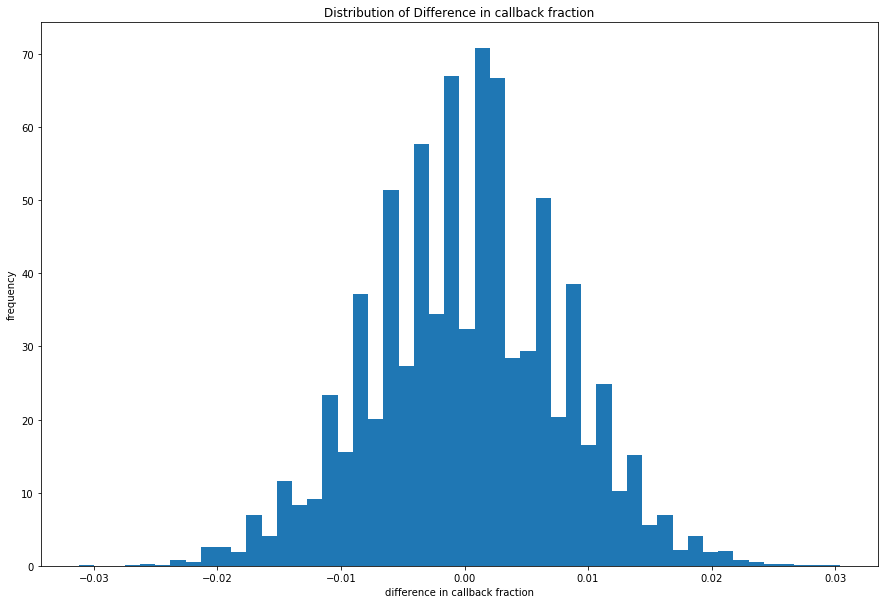

In [19]:
plt.figure(figsize=(15,10))

#resample difference
bs_samples = draw_perm_reps(df_w.call, df_b.call, diff_frac, 10000)

#compute p-value
p = (np.sum(bs_samples <= obs_diff_fracs) +  np.sum(bs_samples >= (obs_diff_fracs * -1))) / 10000

print('p-value: ' + str(p))

#plot results
plt.hist(bs_samples, bins=50, normed=True)
plt.title('Distribution of Difference in callback fraction')
plt.xlabel('difference in callback fraction')
plt.ylabel('frequency')
plt.show()

### 4. Write a story describing the statistical significance in the context or the original problem.
By comparing the difference in fraction of callback response between applications marked either 'b' or 'w', we can conclude that there is a statistically significant difference between the fraction of times the application led to a call back betweem each marker, with applications marked 'b' at 6.4% and applications marked 'w' at 9.7% as observed from within this data set. 

### 5.Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?
While there is a statistically significant difference between the callback rate between applications marked 'b' and 'w', this does not indicate that race/name is the most important factor in callback success. While it does represent a clear and significant difference, the analysis is blind to other factors that could also affect the callback rate (maybe even independent of race/name). Further analysis should seek to find a correlation between callback rate and other factors such as work experience and education level (both coincidentally contained in this data set), and seek to illuminate the distribution of these factors in relation to race/name. If there can be found no further relation between any of the other possible factors, only then could we resonably conclude that race/name was most important factor influencing callback success, and even then only from within confines of factors contained in this data set. 